In [29]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#import seaborn as sns
import argparse
from datetime import datetime
from datetime import timedelta
from matplotlib import cm
from mpl_toolkits.axes_grid1 import AxesGrid
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('npi_canada.csv',
                 lineterminator='\n')

In [4]:
intervention_categories_all = ['C1 School Closing',
                               'C2 Workplace Closures',
                               'C3 Cancel public events',
                               'C4 Public Gathering Restrictions',
                               'C5 Close public transport',
                               'C6 Stay at home requirements',
                               'C7 Restrictions on internal movements',
                               'C8 International Travel Controls',
                               'E1 Income Support',
                               'E2 Debt / Contract Relief for Households',
                               'E3 Fiscal measures',
                               'E4 Support for Other Countries',
                               'H1 Public Info Campaigns', 
                               'H2 Testing policy',
                               'H3 Contact tracing',
                               'H4 Emergency investment in health care',
                               'H5 Investment in vaccines']

       
prov_list = ['Federal', 'Alberta', 'British Columbia', 'Manitoba', 
             'New Brunswick', 'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia', 
             'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon']

In [5]:
gov_res_idx = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'E1', 'E2', 'H1', 'H2', 'H3']
cont_hlth_idx = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'H1', 'H2', 'H3']
stringency_idx = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'H1']
economic_idx = ['E1', 'E2']

closure_code = ['C1', 'C2', 'C3', 'C5', 'C6', 'C7']
restriction_code = ['C4']
travel_code = ['C8']
income_code = ['E1']
relief_code = ['E2']
fiscal_code = ['E3', 'E4', 'H4', 'H5']
info_code = ['H1']
test_code = ['H2']
trace_code = ['H3']

geo_flag = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'H1']
sect_flag = ['E1']


In [6]:
# Setting columns for the empty dataframe
other_cols_all = []
ss = geo_flag + sect_flag
for s in ss:
    other_cols_all.append(f'{s}_flag')

In [7]:
# What are the unique places (country/region/subregion)?
df["subregion"].fillna('All', inplace=True)
df['start_date'] = pd.to_datetime(df['start_date'])  
df_places = df[['country', 'region', 'subregion']].drop_duplicates().sort_values(['region', 'subregion'])

# Make list of unique places, condensing name with underscore separation
unique_places = df_places[['country', 'region', 'subregion']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1).values.tolist()

In [8]:
start_tracking_date = np.datetime64('2020-01-07')
latest_tracking_date = np.datetime64('2020-09-01')
daterange = pd.date_range(start=start_tracking_date,end=latest_tracking_date)

In [9]:
code_dct = {'C4': 'oxford_restriction_code',
            'C8': 'oxford_travel_code',
            'E1': 'oxford_income_amount',
            'E2': 'oxford_debt_relief_code',
            'H1': 'oxford_public_info_code',
            'H2': 'oxford_testing_code',
            'H3': 'oxford_tracing_code'}
for cc in closure_code:
    code_dct[cc] = 'oxford_closure_code'
for fc in fiscal_code:
    code_dct[fc] = 'oxford_fiscal_measure_cad_mod'

In [10]:
code_max = {'C1': 3,
            'C2': 3, 
            'C3': 2,
            'C4': 4,
            'C5': 2,
            'C6': 3,
            'C7': 2,
            'C8': 4,
            'E1': 2,
            'E2': 2,
            'H1': 2,
            'H2': 3,
            'H3': 2}

In [11]:
def parse_cad(string):
    if type(string) == float:
        return string
    cad = string[1:]
    cad = cad.split('.')[0]
    cad = ''.join(cad.split(','))
    try:
        return float(cad)
    except:
        return 0

In [12]:
df['oxford_fiscal_measure_cad_mod'] = df['oxford_fiscal_measure_cad'].apply(parse_cad)

In [13]:
def impute_intervention_index(df_raw, prov):
    
    df_raw2 = df_raw[(df_raw['region'] == prov) & (df_raw['subregion'] == 'All')]
    
    # Make empty dataframe with all the neccesary columns and rows (dates)
    dff = pd.DataFrame( {
        "region" : prov, 
        "date" : daterange,
    })

    #df_return = pd.concat([dff, pd.DataFrame(columns=intervention_categories_all+other_cols_all)], sort=False)
    df_return = pd.concat([dff, pd.DataFrame(columns=intervention_categories_all+other_cols_all)])
    
    df_return["Government response index"] = 0
    df_return["Containment and health index"] = 0
    df_return["Stringency index"] = 0
    df_return["Economic support index"] = 0
    
    for idx, row in df_return.iterrows():
        obs_date = row['date']
#         subset = df_raw2[(df_raw2['start_date'] <= obs_date) & (df_raw2['start_date'] >= obs_date - np.timedelta64(28,'D'))]
        subset = df_raw2[(df_raw2['start_date'] <= obs_date)] 
        gri = 0
        chi = 0
        si = 0
        esi = 0
        
        for iv in intervention_categories_all:
            iv_pref = iv.split(' ')[0]
            subset_iv = subset[subset['oxford_government_response_category'] == iv]
            
            if len(subset_iv[subset_iv['end_date'].isnull() == False]):
                help_subset = subset_iv[subset_iv['end_date'].isnull() == False]
                help_subset['end_date'] = pd.to_datetime(help_subset['end_date'], infer_datetime_format='%Y-%m-%d')
                end_date = help_subset.sort_values(by='end_date',ascending=False)['end_date'].iloc[0]
                if iv_pref not in fiscal_code:
                    if len(subset_iv[subset_iv['start_date'] >= end_date]):
                        subset_iv = subset_iv[subset_iv['start_date'] >= end_date]
            
            if len(subset_iv):                
                if iv_pref in fiscal_code:
                    df_return.at[idx, iv] = np.nansum(subset_iv[code_dct[iv_pref]])
                else:
                    df_return.at[idx, iv] = np.nanmax(subset_iv[code_dct[iv_pref]])
                    if iv_pref in geo_flag:
                        df_return.at[idx, iv_pref + '_flag'] = np.nanmax(subset_iv['oxford_geographic_target_code'])
                    elif iv_pref in sect_flag: 
                        df_return.at[idx, iv_pref + '_flag'] = np.nanmax(subset_iv['oxford_income_target'])
            else:
                if idx:
                    df_return.at[idx, iv] = df_return.iloc[idx-1][iv]
                    if iv_pref in geo_flag:
                        df_return.at[idx, iv_pref + '_flag'] = 0
                    elif iv_pref in sect_flag: 
                        df_return.at[idx, iv_pref + '_flag'] = 0
                else:
                    df_return.at[idx, iv] = 0  
                    if iv_pref in geo_flag:
                        df_return.at[idx, iv_pref + '_flag'] = 0
                    elif iv_pref in sect_flag: 
                        df_return.at[idx, iv_pref + '_flag'] = 0
            
            if iv_pref in cont_hlth_idx:
                
                if iv_pref in geo_flag:
                    iv_val = 100 * (df_return.iloc[idx][iv]- 0.5*(1-df_return.iloc[idx][iv_pref + '_flag'])) / code_max[iv_pref]
                else:
                    iv_val = 100 * df_return.iloc[idx][iv] / code_max[iv_pref]
                
                iv_val = max(0, iv_val)
                gri += iv_val
                chi += iv_val
                if iv_pref in stringency_idx:
                    si += iv_val
                
            if iv_pref in economic_idx:
                if iv_pref in sect_flag:
                    iv_val = 100 * (df_return.iloc[idx][iv]- 0.5*(1-df_return.iloc[idx][iv_pref + '_flag'])) / code_max[iv_pref]
                else:
                    iv_val = 100 * df_return.iloc[idx][iv] / code_max[iv_pref]
                    
                iv_val = max(0, iv_val)
                
                gri += iv_val
                esi += iv_val
        
        df_return.at[idx, "Government response index"] = gri / 13
        df_return.at[idx, "Containment and health index"] = chi / 11
        df_return.at[idx, "Stringency index"] = si / 9
        df_return.at[idx, "Economic support index"] = esi / 2
        
    return df_return


In [14]:
%%time

# Generate temporal stringency index per province
on = impute_intervention_index(df, 'Ontario')
qb = impute_intervention_index(df, 'Quebec')
bc = impute_intervention_index(df, 'British Columbia')
sk = impute_intervention_index(df, 'Saskatchewan')
nb = impute_intervention_index(df, 'New Brunswick')
ns = impute_intervention_index(df, 'Nova Scotia')
mb = impute_intervention_index(df, 'Manitoba')
ab = impute_intervention_index(df, 'Alberta')
nv = impute_intervention_index(df, 'Nunavut')
pei = impute_intervention_index(df, 'Prince Edward Island')
nwt = impute_intervention_index(df, 'Northwest Territories')
nl = impute_intervention_index(df, 'Newfoundland and Labrador')
yt = impute_intervention_index(df, 'Yukon')

prov_dict = {'Ontario': on,
            'Quebec': qb,
            'British Columbia': bc,
            'Saskatchewan': sk,
            'New Brunswick': nb,
            'Nova Scotia': ns,
            'Manitoba' : mb,
            'Alberta' : ab,
            'Prince Edward Island': pei,
            'Nunavut': nv,
            'Northwest Territories' : nwt,
            'Newfoundland and Labrador' : nl,
            'Yukon': yt}


CPU times: user 5min 15s, sys: 711 ms, total: 5min 16s
Wall time: 5min 16s


In [15]:
canada = pd.DataFrame(columns=['date', 'region', 'Government response index',
       'Containment and health index', 'Stringency index',
       'Economic support index'])
for k, v in prov_dict.items():
    
    canada = pd.concat([canada, v[['date', 'region', 'Government response index',
       'Containment and health index', 'Stringency index',
       'Economic support index']]])

for index_type in ['Government response index',
       'Containment and health index', 'Stringency index',
       'Economic support index']:
    canada[index_type] = pd.to_numeric(canada[index_type])
canada['region'] = canada['region'].apply(str)
canada['date'] = pd.to_datetime(canada['date'])  

In [16]:
canada['date'] = canada['date'].dt.strftime('%m/%d')

In [24]:
heatmap_data = pd.pivot_table(canada, values='Government response index', 
                     index=['region'],
                     columns='date')



In [26]:
heatmap_data

date,01/07,01/08,01/09,01/10,01/11,01/12,01/13,01/14,01/15,01/16,...,08/23,08/24,08/25,08/26,08/27,08/28,08/29,08/30,08/31,09/01
region,,,,,,,,,,,,,,,,,,,,,
Alberta,0,0,0,0,0,0,0,0,0,0,...,30,30,30,30,30,30,30,30,30,30
British Columbia,0,0,0,0,0,0,0,0,0,0,...,35,35,35,35,35,35,35,35,35,35
Manitoba,0,0,0,0,0,0,0,0,0,0,...,25,25,25,25,25,25,25,25,25,25
New Brunswick,0,0,0,0,0,0,0,0,0,0,...,53,53,53,53,53,53,53,53,53,53
Newfoundland and Labrador,0,0,0,0,0,0,0,0,0,0,...,48,48,48,48,48,48,48,48,48,48
Northwest Territories,0,0,0,0,0,0,0,0,0,0,...,44,44,44,44,44,44,44,44,44,44
Nova Scotia,0,0,0,0,0,0,0,0,0,0,...,25,25,25,25,25,25,25,25,25,25
Nunavut,0,0,0,0,0,0,0,0,0,0,...,34,34,34,34,34,34,34,34,34,34
Ontario,0,0,0,0,0,0,0,0,0,0,...,51,51,51,51,51,51,51,51,51,51


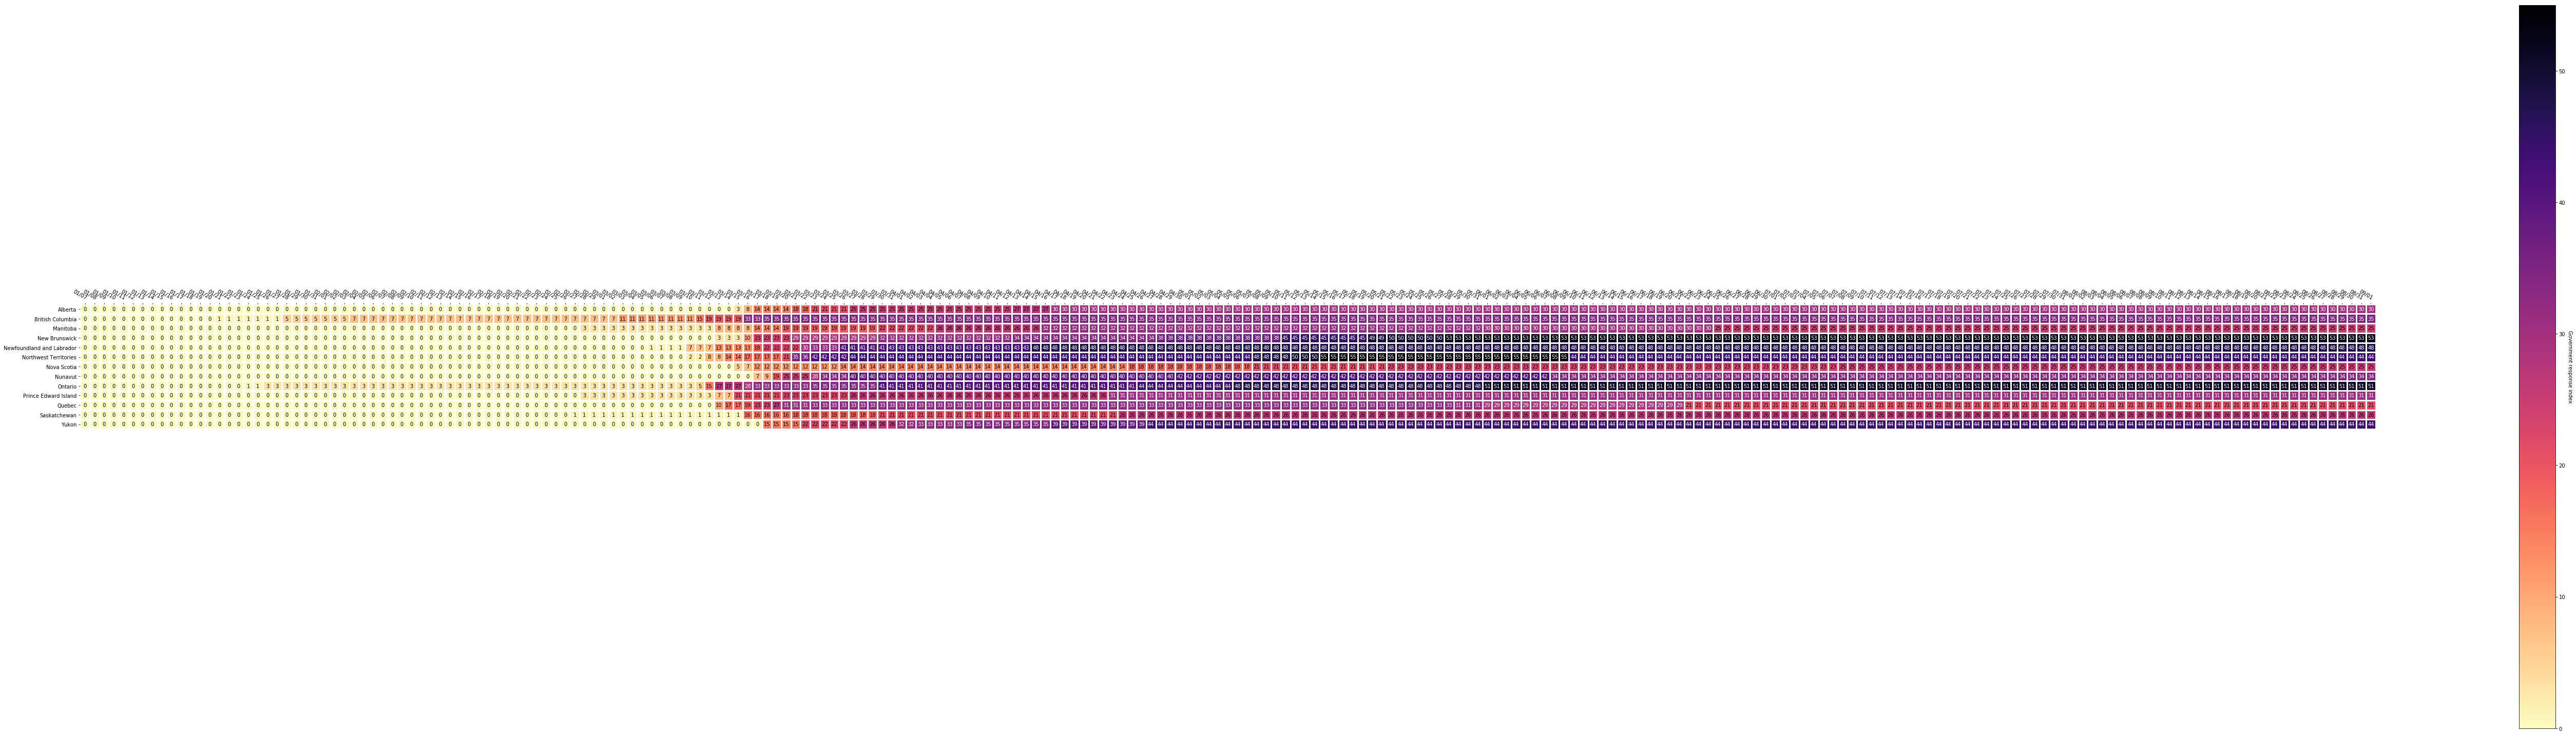

In [33]:
fig, ax = plt.subplots(figsize=(80,20))

#nice_date = [x.strftime('%B %d') for x in heatmap_data.columns.values]

im, cbar = heatmap(heatmap_data.values, heatmap_data.index.values, heatmap_data.columns.values, ax=ax,
                   cmap="magma_r", cbarlabel="Government response index")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.savefig('oxford.png', dpi=300)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (15, 7))
sns.heatmap(heatmap_data, cmap="magma_r",
            vmin=0, vmax=100)
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('June 18th_Government response index Map.png')

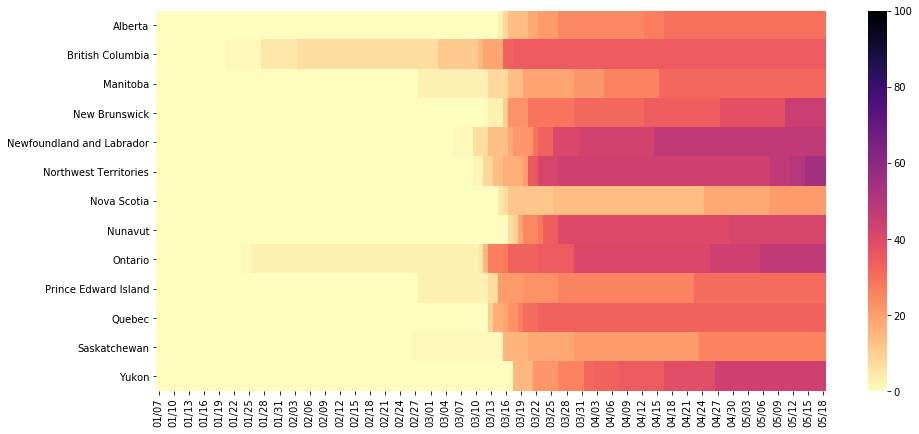

In [16]:
heatmap_data = pd.pivot_table(canada, values='Government response index', 
                     index=['region'],
                     columns='date')

fig, ax = plt.subplots(1, 1, figsize = (15, 7))
sns.heatmap(heatmap_data, cmap="magma_r",
            vmin=0, vmax=100)
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('June 18th_Government response index Map.png')

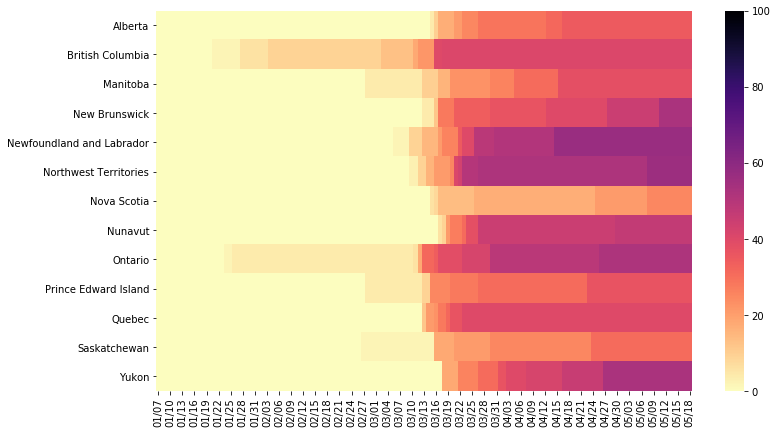

In [17]:
# canada['date'] = canada['date'].dt.strftime('%m/%d')
heatmap_data = pd.pivot_table(canada, values='Containment and health index', 
                     index=['region'], 
                     columns='date')

fig, ax = plt.subplots(1, 1, figsize = (12, 7))
sns.heatmap(heatmap_data, cmap="magma_r",
            vmin=0, vmax=100)
ax.set_xlabel('')
ax.set_ylabel('')
plt.savefig('June 18th_Stringency index Map.png')

In [17]:
canada.to_csv('canadian_npi_oxford.csv', index=False)

In [23]:
for k, v in prov_dict.items():
    v.to_csv('oxford/'+k+'.csv', index=False)

In [25]:
# Thanks to matplotlib documentation for this

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts